### Data Collection and Preprocessing

Work with the Caltech101 dataset. Preprocessing usually involves resizing the images to a consistent size and normalize the pixel values.

In [3]:
import tensorflow as tf
from keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import itertools

Matplotlib is building the font cache; this may take a moment.


Preparamos los datos antes de entrenar una red convolucional, en este caso train_dataset (Contiene los datos de entrenamiento), test_dataset (Contiene los datos de prueba) y dataset_info (Contiene la información adicional sobre el conjunto de datos). 

In [4]:
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
    data_dir='./data'
)

c:\Users\Geovanny\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [00:30<00:00, 28.91s/ url]

Extraction completed...: 100%|██████████| 9145/9145 [02:36<00:00, 58.36 file/s]  


Dataset caltech101 downloaded and prepared to ./data\caltech101\3.0.2. Subsequent calls will reuse this data.


Obtenemos las clases o etiquetas.

In [5]:
name_classes = dataset_info.features['label'].names
name_classes

['accordion',
 'airplanes',
 'anchor',
 'ant',
 'background_google',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'faces',
 'faces_easy',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'leopards',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'motorbikes',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooste

Con esta función tomamos una imagen y su etiqueta, y redimensionaremos la imagen a un tamaño de 224x224 píxeles ya que usaremos una arquitectura de red convolucional preentrenada que es la VGG16 que trabaja con tamaños de 224. Despues normalizamos los píxeles de la imagen al rango [0, 1] porque los valores de los píxeles originales suelen estar en el rango [0, 255]. 

In [6]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

LLamamos a la función preprocess_image a cada imagen y su etiqueta en el conjunto de datos, en donde redimensionamos y normalizamos la imagenes. Usaremos suffle para mezclar aleatoriamente los datos y seleccionaremos aleatoriamente elementos de este buffer para producir el conjunto de datos mezclado. Y por ultimos agruparemos los datos en lotes de 32, para entrenar el modelo en mini-lotes en lugar de uno por uno.

In [7]:
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
test_dataset = test_dataset.map(preprocess_image).batch(32)

In [8]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Feature Extraction

Use a pre-trained CNN model (e.g., VGG16) to extract features from the images.

Remove the top layers to get the feature vectors.

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

Para base_model tenemos que especificar las siguientes datos:

weights: especifica que se deben cargar los pesos preentrenados en el conjunto de datos ImageNet. Esto permite aprovechar el aprendizaje previo realizado en este gran conjunto de datos para tareas de clasificación,.

include_top: Indica que no se debe incluir la parte superior ya que vamos a utilizar la red como un extractor de características.

input_shape: Define la forma de entrada de las imágenes, que en este caso será 224x224 píxeles con 3 canales de color (RGB).

Despues creamos un nuevo modelo Keras pasando los datos de base_model, y definimos la salida del nuevo modelo como la salida de la última capa convolucional del modelo base_model.

In [10]:
# Load the VGG16 model with pretrained weights from ImageNet, without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model that outputs the feature maps
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Extraemos las caracteristicas usando el modelo que creamos, pero tambien guardamos las imagenes y sus etiquetas.

In [11]:
# Function to extract features
def extract_features(dataset):
    features = []
    labels = []
    imgs = []
    for images, lbls in dataset:
        imgs.append(images)
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
    return features, labels,imgs

Extraemos para el train y el test las caracteristicas, imagenes y sus etiquetas .

In [12]:
# Extract features for train and test datasets
train_features, train_labels,train_img = extract_features(train_dataset)
test_features, test_labels,test_img = extract_features(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

### Indexing

Use an in-memory index using NumPy. Other alternatives are more scalable solutions like FAISS or an approximate nearest neighbor search library.

Convertimos en listas de lotes de datos en listas planas o arreglos NumPy. Este proceso de aplanado facilita la manipulación y el análisis de los datos

In [13]:
# Flatten the feature maps to create feature vectors, Aplana cada característica en un vector unidimensional. Convierte la lista de características aplanadas en un arreglo NumPy
train_features_flat = np.array([feature.flatten() for batch in train_features for feature in batch])
train_labels_flat = np.array([label for batch in train_labels for label in batch])
train_img_flat = np.array([img for batch in train_img for img in batch])
test_img_flat = np.array([img for batch in test_img for img in batch])

Guardamos las caracteristicas, etiquetas y imagenes en un numpy. Y despues lo cargamos para evitar entrenar de nuevo.

In [14]:
# Optionally, save the features and labels for later use
np.save('train_features.npy', train_features_flat)
np.save('train_labels.npy', train_labels_flat)
np.save('train_img.npy', train_img_flat)
np.save('test_img.npy', test_img_flat)

In [15]:
# Load the saved features and labels
train_features_flat = np.load('train_features.npy')
train_labels_flat = np.load('train_labels.npy')
train_img_flat = np.load('train_img.npy')
test_img_flat = np.load('test_img.npy')

In [21]:
# Example query: Retrieve the 5 nearest neighbors for a test image
from sklearn.neighbors import NearestNeighbors

Entrenamos un modelo de Nearest Neighbors utilizando el algoritmo ball_tree para encontrar los vecinos más cercanos en un espacio de características aplanadas.

In [22]:
# Fit the NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_features_flat)

Añadimos una dimensión extra al tensor, haciendo que se vea como un lote que contiene una sola imagen. Esta expansión es útil para pasar la imagen a un modelo que espera lotes de datos. 

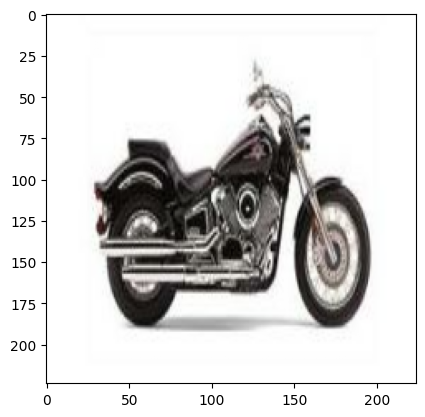

In [23]:
imagen_consulta =test_img_flat[2]
imagen_consulta = tf.expand_dims(imagen_consulta, axis=0)
plt.imshow(imagen_consulta[0])

 Usamos el modelo previamente entrenado para extraer las características de la imagen de consulta, Aplanamos con flatten las características extraídas de una matriz multidimensional a un vector unidimensional ya que el modelo de Nearest Neighbors necesita que esten de esa forma. y reorganiza el vector unidimensional en una matriz de una sola fila

In [24]:
query_features = model.predict([imagen_consulta]).flatten().reshape(1, -1)
# Find the nearest neighbors, encontrar los vecinos más cercanos a las características de la imagen de consulta
distances, indices = nn_model.kneighbors(query_features)
print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Indices of nearest neighbors: [[1671 2910  265  318 2132]]
Distances to nearest neighbors: [[30.97731524 31.1232516  37.39177133 38.02494398 38.82652905]]


Recuperamos las imágenes de los vecinos más cercanos usando los índices.

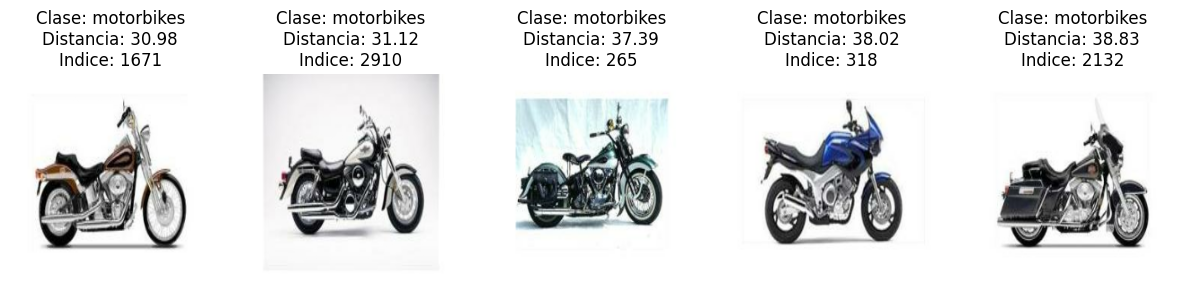

In [25]:
nearest_images =[]
nearest_labels = []
# Recuperar las imágenes de los vecinos más cercanos usando los índices
nearest_images = [train_img_flat[i] for i in indices.flatten()]
nearest_labels = [train_labels_flat[i] for i in indices.flatten()]
plt.figure(figsize=(15, 3))  # Ajustar el tamaño de la figura
for i, image in enumerate(nearest_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title("Clase: " + name_classes[nearest_labels[i]] + "\nDistancia: " + str(round(distances[0][i], 2))+ "\nIndice: " + str(indices[0][i]))
    plt.axis('off')
plt.show()